In [1]:
# https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

In [2]:
import sys
sys.executable

'/home/codespace/anaconda3/bin/python'

In [68]:
import pandas as pd
import sklearn 

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from lifelines import KaplanMeierFitter

from sklearn.feature_extraction import DictVectorizer

In [55]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-04.parquet')
df = df[df.trip_type == 2]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
11,2,2024-04-01 00:33:32,2024-04-01 00:34:23,N,5.0,132,132,1.0,0.11,13.0,0.0,0.0,0.01,0.0,NaN,1.0,14.01,1.0,2.0,0.0
12,2,2024-04-01 00:54:59,2024-04-01 00:55:13,N,5.0,7,7,1.0,0.00,149.0,0.0,0.0,0.00,0.0,NaN,1.0,150.00,2.0,2.0,0.0
15,2,2024-04-01 00:08:17,2024-04-01 00:09:13,N,5.0,53,53,1.0,0.08,20.0,0.0,0.0,0.00,0.0,NaN,1.0,21.00,2.0,2.0,0.0
17,2,2024-04-01 00:20:02,2024-04-01 00:20:04,N,5.0,264,264,2.0,0.00,45.0,0.0,0.0,0.00,0.0,NaN,1.0,46.00,1.0,2.0,0.0
30,2,2024-04-01 01:02:06,2024-04-01 01:02:39,N,5.0,75,264,1.0,0.00,10.0,0.0,0.0,0.00,0.0,NaN,1.0,11.00,1.0,2.0,0.0


In [56]:
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [57]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [58]:
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60) # time in minutes
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
11,2,2024-04-01 00:33:32,2024-04-01 00:34:23,N,5.0,132,132,1.0,0.11,13.0,...,0.0,0.01,0.0,NaN,1.0,14.01,1.0,2.0,0.0,0.850000
12,2,2024-04-01 00:54:59,2024-04-01 00:55:13,N,5.0,7,7,1.0,0.00,149.0,...,0.0,0.00,0.0,NaN,1.0,150.00,2.0,2.0,0.0,0.233333
15,2,2024-04-01 00:08:17,2024-04-01 00:09:13,N,5.0,53,53,1.0,0.08,20.0,...,0.0,0.00,0.0,NaN,1.0,21.00,2.0,2.0,0.0,0.933333
17,2,2024-04-01 00:20:02,2024-04-01 00:20:04,N,5.0,264,264,2.0,0.00,45.0,...,0.0,0.00,0.0,NaN,1.0,46.00,1.0,2.0,0.0,0.033333
30,2,2024-04-01 01:02:06,2024-04-01 01:02:39,N,5.0,75,264,1.0,0.00,10.0,...,0.0,0.00,0.0,NaN,1.0,11.00,1.0,2.0,0.0,0.550000


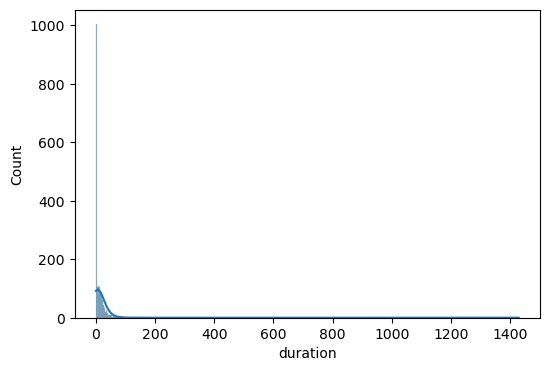

In [59]:
plt.figure(figsize=(6, 4))

sns.histplot(df.duration, kde=True)

plt.show()

In [60]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    2094.000000
mean       15.758604
std        82.619374
min         0.000000
50%         3.716667
95%        40.217500
98%        61.137333
99%        82.415500
max      1428.933333
Name: duration, dtype: float64

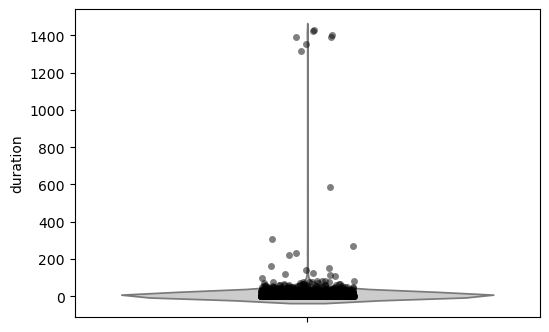

In [61]:
plt.figure(figsize=(6, 4))

# Create the violin plot
sns.violinplot(y='duration', data=df, inner=None, color=".8")
sns.stripplot(y='duration', data=df, jitter=True, color='k', alpha=0.5)

# Show the plot
plt.show()

In [62]:
((df.duration >= 0) & (df.duration <= 100)).mean()

0.9909264565425024

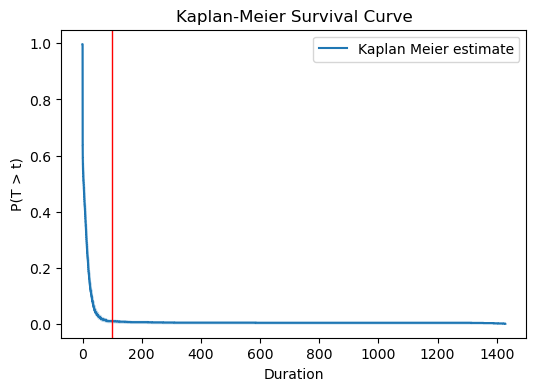

In [63]:
sa_df = df[['duration']].copy() 
sa_df['status'] = 1


km = KaplanMeierFitter()
km_time = km.fit(sa_df['duration'], event_observed=sa_df['status'])

fig, ax = plt.subplots(figsize=(6,4))
km_time.plot_survival_function(label='Kaplan Meier estimate', ax=ax)

# kmf.plot_survival_function()

ax.axvline(x=100, color='red', linestyle='-', linewidth=1) 

ax.set_title('Kaplan-Meier Survival Curve')
ax.set_xlabel('Duration')
ax.set_ylabel('P(T > t)')
ax.legend()

plt.show()


In [64]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')

In [65]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [66]:
df[categorical] = df[categorical].astype(str)
df.dtypes

VendorID                          int32
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [73]:
train_dics = df[categorical + numerical].to_dict(orient='records')
train_dics

[{'PULocationID': '132', 'DOLocationID': '132', 'trip_distance': 0.11},
 {'PULocationID': '7', 'DOLocationID': '7', 'trip_distance': 0.0},
 {'PULocationID': '53', 'DOLocationID': '53', 'trip_distance': 0.08},
 {'PULocationID': '264', 'DOLocationID': '264', 'trip_distance': 0.0},
 {'PULocationID': '75', 'DOLocationID': '264', 'trip_distance': 0.0},
 {'PULocationID': '75', 'DOLocationID': '148', 'trip_distance': 7.37},
 {'PULocationID': '75', 'DOLocationID': '148', 'trip_distance': 7.37},
 {'PULocationID': '134', 'DOLocationID': '134', 'trip_distance': 0.77},
 {'PULocationID': '255', 'DOLocationID': '255', 'trip_distance': 0.0},
 {'PULocationID': '41', 'DOLocationID': '94', 'trip_distance': 6.3},
 {'PULocationID': '235', 'DOLocationID': '42', 'trip_distance': 3.08},
 {'PULocationID': '264', 'DOLocationID': '264', 'trip_distance': 0.14},
 {'PULocationID': '83', 'DOLocationID': '83', 'trip_distance': 0.0},
 {'PULocationID': '42', 'DOLocationID': '248', 'trip_distance': 6.35},
 {'PULocation

In [80]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dics)
target = df.duration